# COVID-19 Health Policies
*** For specific Countries ***
(Australia, Senegal, Egypt, China)


## Import required modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None # default='warn'

## Read in data

In [3]:
# Read in the data
epi_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv", 
                       keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

gr_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv",
                      keep_default_na=False, na_values=[""], parse_dates=['date'], index_col=['date'])

demo_data = pd.read_csv("https://storage.googleapis.com/covid19-open-data/v2/demographics.csv", 
                       keep_default_na=False, na_values=[""])

xls = pd.ExcelFile("https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx")
fc_data = pd.read_excel(xls, 'h6_facial_coverings')

## Get Specific Country Dataframes to work with
* Need epidemiology dataframe for each country
* Need government response dataframe for each country

In [4]:
# Country Codes 
# 1. New Zealand       NZ
# 2. Australia         AU
# 3. Singapore         SG  
# 4. Thailand          TH
# 5. Somalia           SO

# YELLOW
# 1. China             CN   
# 2. Egypt             EG
# 3. Israel            IL
# 4. Kyrgyzstan        KG
# 5. Tajikistan        TJ

# RED
# 1. USA               US
# 2. Brazil            BR
# 3. Canada            CA
# 4. Philippines       PH
# 5. Russia            RU


start_remove = ('2019-12-30')
end_remove = ('2019-12-31')
epi_data = epi_data.loc[(epi_data.index < start_remove) | (epi_data.index > end_remove)]

def preprocess_fc_data(data):
    data.columns = ['face_covering']
    data.index.name = 'date'
    data.index = pd.to_datetime(data.index)
    return data

def preprocess_data(epi_data, gr_data, fc_data, demo_data, code1, code2):
    epi_df = epi_data[(epi_data.key) == code1]
    epi_df['rolling_cases'] = epi_df['new_confirmed'].rolling(7).mean()
    gr_df = gr_data[(gr_data.key) == code1]
    fc_df = fc_data[(fc_data.country_code) == code2].drop(columns=['country_code', 'country_name']).T
    fc_df = preprocess_fc_data(fc_df)
    demo_df = demo_data[(demo_data.key == code1)]
    return epi_df, gr_df, fc_df, demo_df

us_epi_df, us_gr_df, us_fc_df, us_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'US', 'USA')
au_epi_df, au_gr_df, au_fc_df, au_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'AU', 'AUS')
sn_epi_df, sn_gr_df, sn_fc_df, sn_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'SN', 'SEN')
eg_epi_df, eg_gr_df, eg_fc_df, eg_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'EG', 'EGY')
cn_epi_df, cn_gr_df, cn_fc_df, cn_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'CN', 'CHN')

# Extra Countries
ru_epi_df, ru_gr_df, ru_fc_df, ru_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'RU', 'RUS')
ca_epi_df, ca_gr_df, ca_fc_df, ca_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'CA', 'CAN')
th_epi_df, th_gr_df, th_fc_df, th_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'TH', 'THA')
br_epi_df, br_gr_df, br_fc_df, br_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'BR', 'BRA')
sg_epi_df, sg_gr_df, sg_fc_df, sg_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'SG', 'SGP')
nz_epi_df, nz_gr_df, nz_fc_df, nz_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'NZ', 'NZL')
il_epi_df, il_gr_df, il_fc_df, il_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'IL', 'ISR')
ph_epi_df, ph_gr_df, ph_fc_df, ph_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'PH', 'PHL')
gb_epi_df, gb_gr_df, gb_fc_df, gb_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'GB', 'GBR')
de_epi_df, de_gr_df, de_fc_df, de_demo_df = preprocess_data(epi_data, gr_data, fc_data, demo_data, 'DE', 'DEU')

# epidemiology data consists of the following columns
# date, key, new_confirmed, new_deceased, new_recovered, new_tested, total_confirmed, total_deceased,
# total_recovered, total_tested

# government response data consists of many columns. Can see them here
# https://github.com/OxCGRT/covid-policy-tracker/blob/master/documentation/codebook.md#containment-and-closure-policies

# Create necessary Data for Plotting

In [5]:
def plot_health_policies(epi_data, gr_data, fc_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Health Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')
    
    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['testing_policy']/3,
            color='red',
            label='testing')

    ax2.plot(gr_data.index.values,
            gr_data['contact_tracing']/2,
            color='orange',
            label='contact tracing')
    
    ax2.plot(fc_data.index.values,
            fc_data['face_covering']/4,
            color='purple',
            label='face covering')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()
    
def plot_containment_policies(epi_data, gr_data, demo_data, country):
    case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
    fig = plt.figure(1, figsize=(15, 7))
    ax = fig.add_subplot(111)
    ax.set(xlabel='Month',
           ylabel='Daily New Cases per 100K People (7-day avg)',
           title=country + ' Containment Policies vs Cases')
    ax.set_ylim([-case_rate_100K.max(), case_rate_100K.max()])
    ticks = [tick for tick in plt.gca().get_yticks() if tick >= 0]
    plt.gca().set_yticks(ticks)
    
    ax.yaxis.set_label_coords(-0.05, 0.75)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('axes', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_smart_bounds(True)
    
    ax.plot(epi_data.index.values,
            case_rate_100K,
            color='blue',
            label='new cases per 100K people')

    ax2 = ax.twinx()
    ax2.set(ylabel='Policy Rigour')
    ax2.set_ylim([0,3])
    ticks = [tick for tick in plt.gca().get_yticks() if tick <= 1]
    plt.gca().set_yticks(ticks)
    ax2.yaxis.set_label_coords(-0.05, 0.15)
    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    
    ax2.spines['right'].set_position(('axes', 0))
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_smart_bounds(True)
    
    ax2.plot(gr_data.index.values,
            gr_data['restrictions_on_gatherings']/4,
            color='red',
            label='gathering restrictions')

    ax2.plot(gr_data.index.values,
            gr_data['workplace_closing']/3,
            color='orange',
            label='workplace closures')

    ax2.plot(gr_data.index.values,
            gr_data['school_closing']/3,
            color='purple',
            label='school closures')

    ax2.plot(gr_data.index.values,
            gr_data['stay_at_home_requirements']/3,
            color='yellow',
            label='stay at home orders')

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
    plt.legend(handles,labels)
    plt.show()

In [15]:
def containment_index(epi_data, gr_data, demo_data, country, plot=False):
    C1 = gr_data['school_closing']/3
    #display(max(C1))
    C2 = gr_data['workplace_closing']/3
    #display(max(C2))
    C3 = gr_data['cancel_public_events']/2
    #display(max(C3))
    C4 = gr_data['restrictions_on_gatherings']/4
    #display(max(C4))
    C5 = gr_data['public_transport_closing']/2
    #display(max(C5))
    C6 = gr_data['stay_at_home_requirements']/3
    #display(max(C6))
    C7 = gr_data['restrictions_on_internal_movement']/2
    #display(max(C7))
    C8 = gr_data['international_travel_controls']/4
    #display(max(C8))
    
    gr_data['contain_policy_avg'] = ((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8) / 8 ) * 100
    #gr_data['contain_policy_avg'] /= (demo_data['population'].values[0] / 100000)
    #display(max((C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8)))
    
    gr_containment_idx = gr_data['contain_policy_avg'].sum()/len(gr_data)
    print(country, 'containment index: ', gr_containment_idx)
    #display(max(gr_data['contain_policy_avg']))

    if plot == True:
        case_rate_100K = epi_data['rolling_cases']/demo_data['population'].values[0]*100000
        fig = plt.figure(1, figsize=(8, 4))
        ax = fig.add_subplot(111)
        ax.set(xlabel='Month',
               ylabel='Daily New Cases per 100K People (7-day avg)',
               title=country + ' Containment Index vs Cases')
        ax.set_ylim([0, 75])
        ax.plot(epi_data.index.values,
                case_rate_100K,
                color='blue',
                label='new cases per 100K people')

        ax2 = ax.twinx()
        ax2.set_ylim([0,100])
        ax2.set(ylabel='Containment Index')
        ax2.plot(gr_data.index.values,
                gr_data['contain_policy_avg'],
                color='red',
                label='containment index')
        
        ax2.plot(gr_data.index.values,
                gr_data['stringency_index'],
                color='green',
                label='stringency index')
        
        handles,labels = [],[]
        for ax in fig.axes:
            for h,l in zip(*ax.get_legend_handles_labels()):
                handles.append(h)
                labels.append(l)
        ax.set_xlim([dt.date(2020, 1, 1), dt.date(2020, 12, 1)])
        plt.legend(handles,labels)
        plt.show()
    return gr_data, gr_containment_idx

US containment index:  64.36420223577237


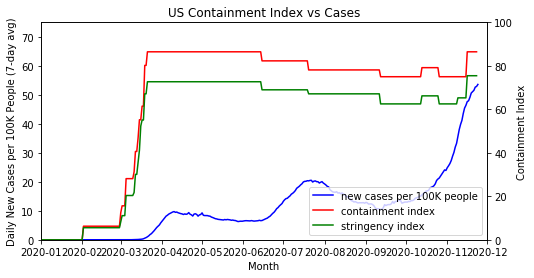

AU containment index:  59.48208722741433


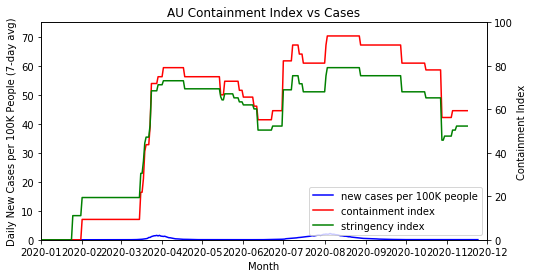

SN containment index:  36.02959857723577


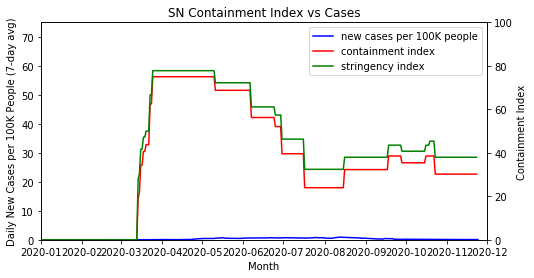

EG containment index:  50.78923824130879


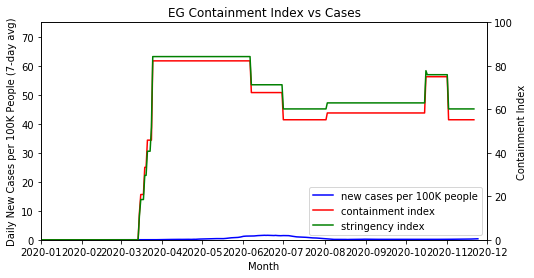

CN containment index:  79.1922290388548


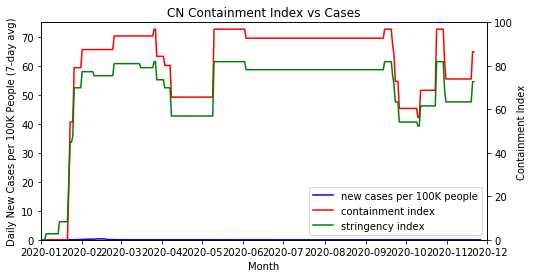

RU containment index:  56.842507645259936


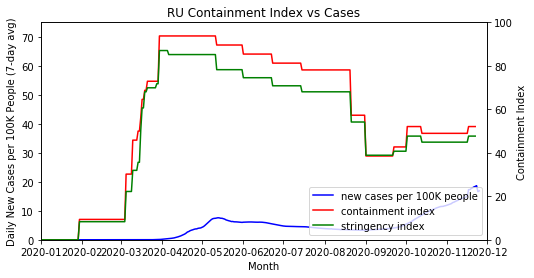

CA containment index:  57.45462678936604


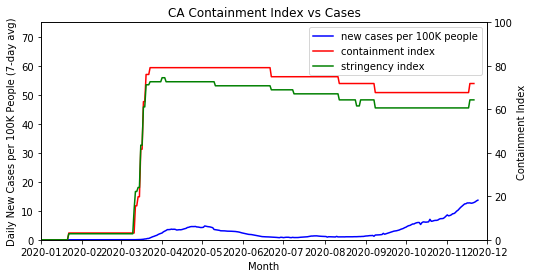

TH containment index:  44.267638036809814


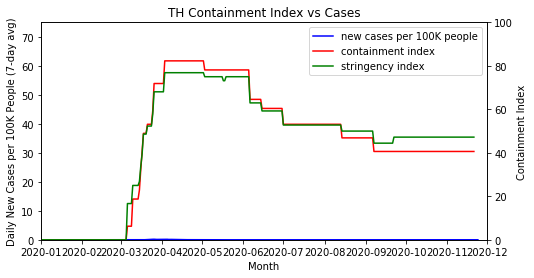

BR containment index:  65.80672377985462


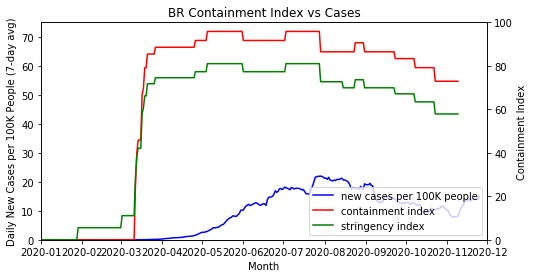

SG containment index:  45.29344512195122


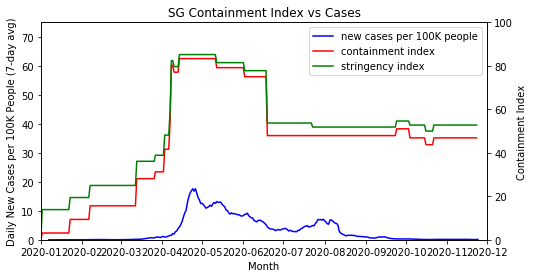

NZ containment index:  31.191950464396285


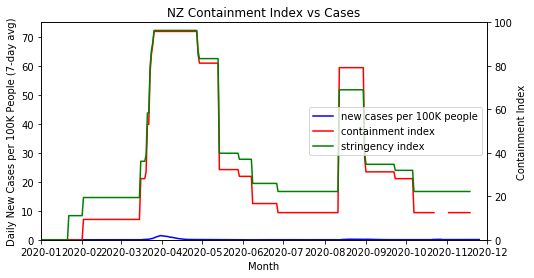

IL containment index:  53.194867886178855


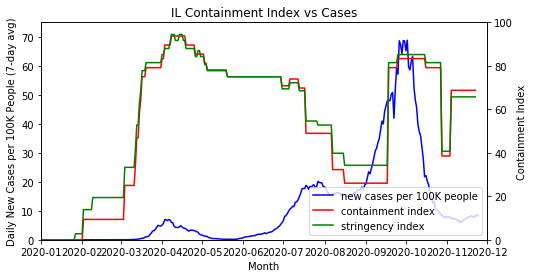

PH containment index:  67.43521341463415


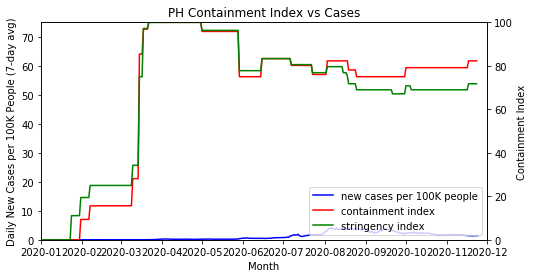

GB containment index:  54.247793354101766


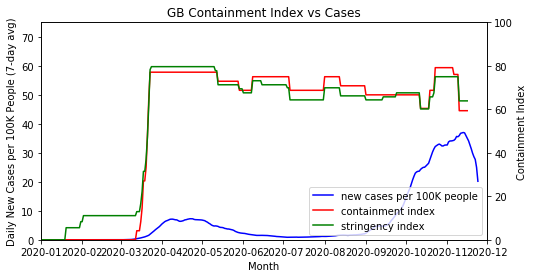

DE containment index:  48.22850318471336


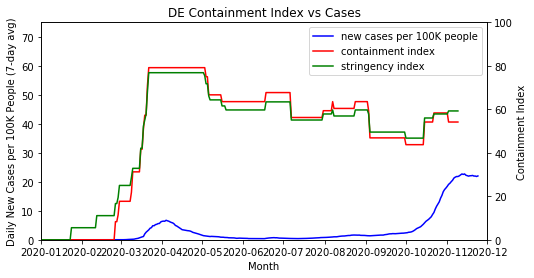

In [16]:
us_gr_df, us_cont_idx = containment_index(us_epi_df, us_gr_df, us_demo_df, 'US', plot=True)
au_gr_df, au_cont_idx = containment_index(au_epi_df, au_gr_df, au_demo_df, 'AU', plot=True)
sn_gr_df, sn_cont_idx = containment_index(sn_epi_df, sn_gr_df, sn_demo_df, 'SN', plot=True)
eg_gr_df, eg_cont_idx = containment_index(eg_epi_df, eg_gr_df, eg_demo_df, 'EG', plot=True)
cn_gr_df, cn_cont_idx = containment_index(cn_epi_df, cn_gr_df, cn_demo_df, 'CN', plot=True)

ru_gr_df, ru_cont_idx = containment_index(ru_epi_df, ru_gr_df, ru_demo_df, 'RU', plot=True)
ca_gr_df, ca_cont_idx = containment_index(ca_epi_df, ca_gr_df, ca_demo_df, 'CA', plot=True)
th_gr_df, th_cont_idx = containment_index(th_epi_df, th_gr_df, th_demo_df, 'TH', plot=True)
br_gr_df, br_cont_idx = containment_index(br_epi_df, br_gr_df, br_demo_df, 'BR', plot=True)
sg_gr_df, sg_cont_idx = containment_index(sg_epi_df, sg_gr_df, sg_demo_df, 'SG', plot=True)
nz_gr_df, nz_cont_idx = containment_index(nz_epi_df, nz_gr_df, nz_demo_df, 'NZ', plot=True)
il_gr_df, il_cont_idx = containment_index(il_epi_df, il_gr_df, il_demo_df, 'IL', plot=True)
ph_gr_df, ph_cont_idx = containment_index(ph_epi_df, ph_gr_df, ph_demo_df, 'PH', plot=True)
gb_gr_df, gb_cont_idx = containment_index(gb_epi_df, gb_gr_df, gb_demo_df, 'GB', plot=True)
de_gr_df, de_cont_idx = containment_index(de_epi_df, de_gr_df, de_demo_df, 'DE', plot=True)

# Plot United States Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

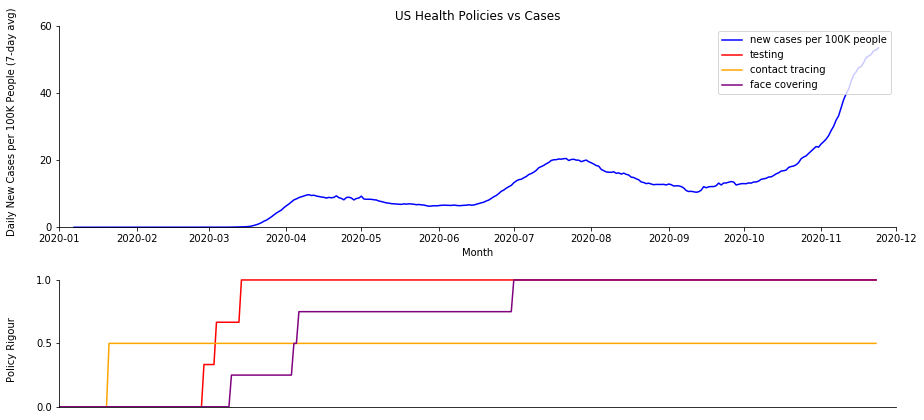

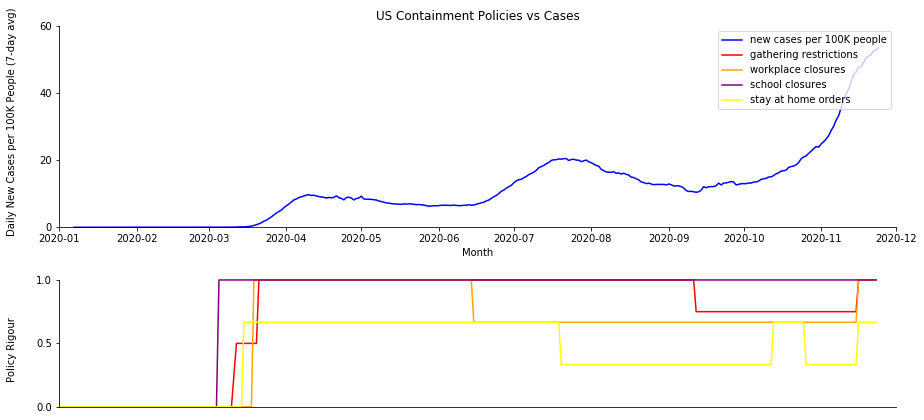

In [7]:
plot_health_policies(us_epi_df, us_gr_df, us_fc_df, us_demo_df, 'US')
plot_containment_policies(us_epi_df, us_gr_df, us_demo_df, 'US')

# Plot Australia Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

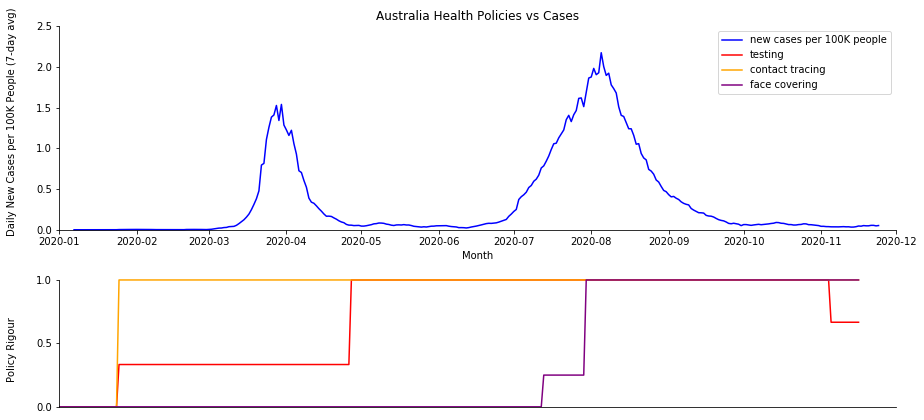

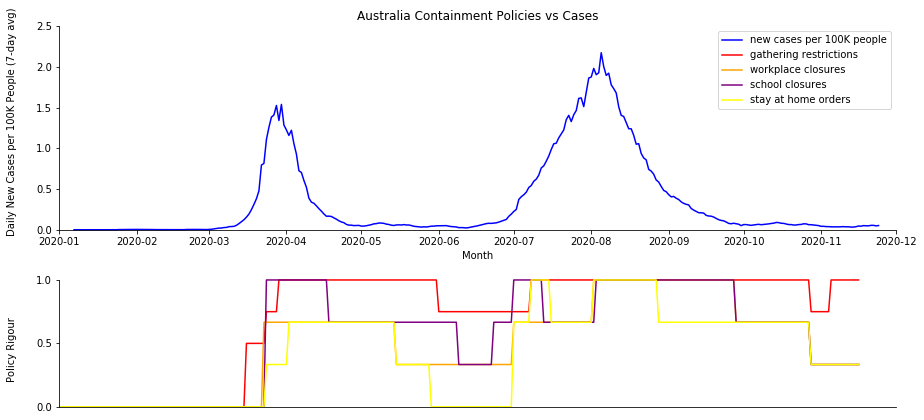

In [8]:
plot_health_policies(au_epi_df, au_gr_df, au_fc_df, au_demo_df, 'Australia')
plot_containment_policies(au_epi_df, au_gr_df, au_demo_df, 'Australia')

# Plot Senegal Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

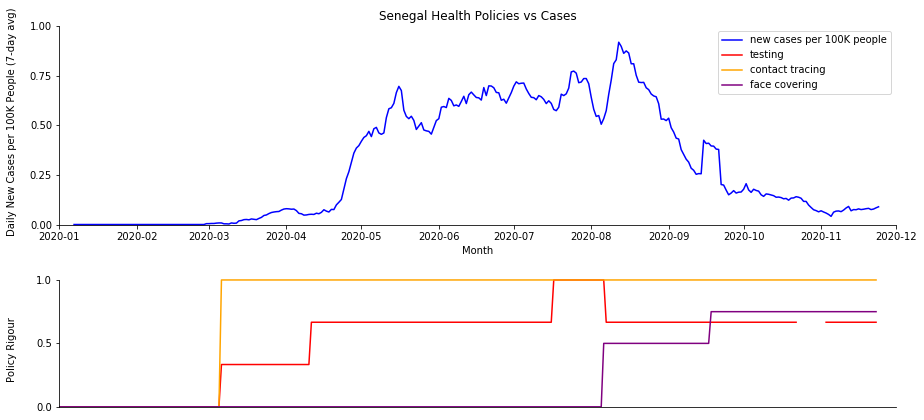

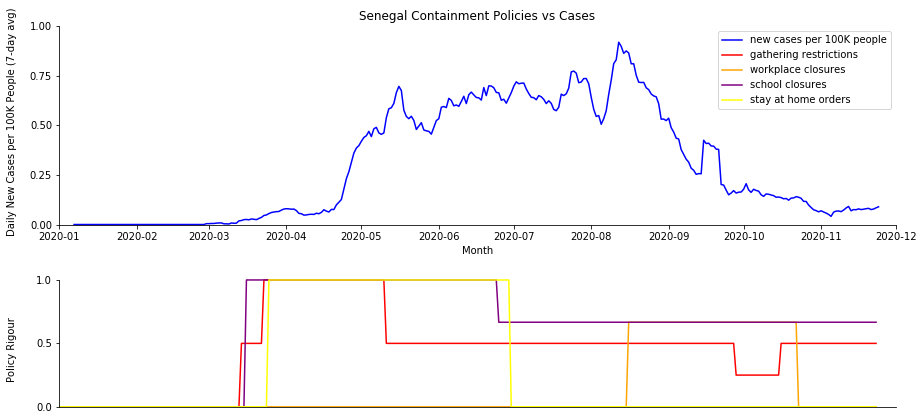

In [9]:
plot_health_policies(sn_epi_df, sn_gr_df, sn_fc_df, sn_demo_df, 'Senegal')
plot_containment_policies(sn_epi_df, sn_gr_df, sn_demo_df, 'Senegal')

# Plot Egypt Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

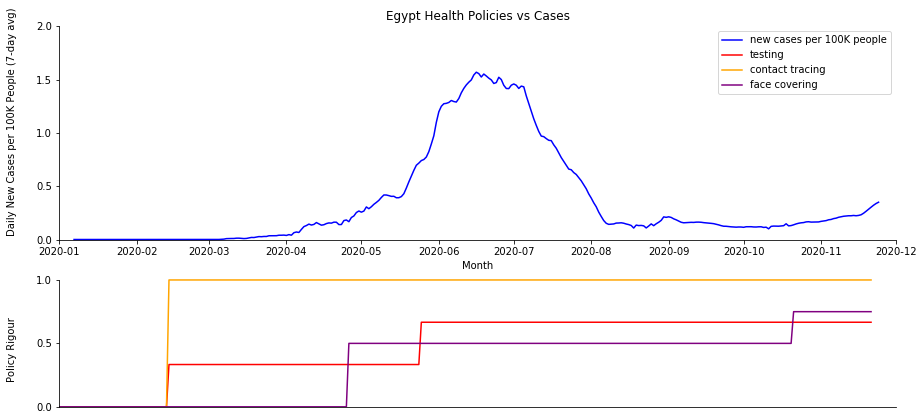

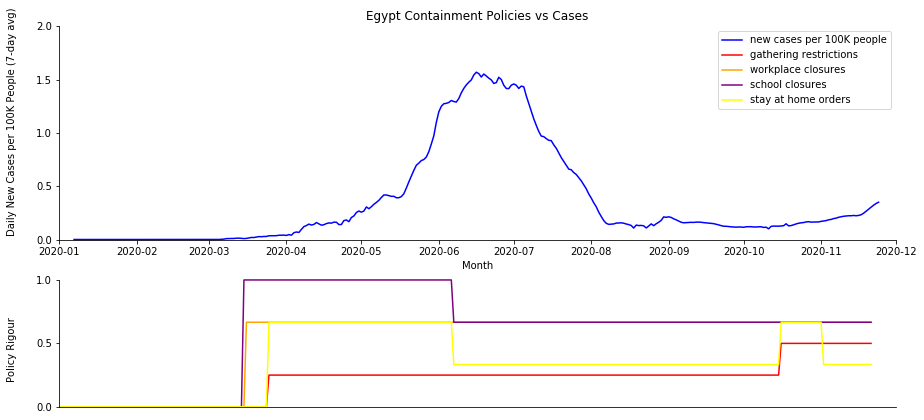

In [10]:
plot_health_policies(eg_epi_df, eg_gr_df, eg_fc_df, eg_demo_df, 'Egypt')
plot_containment_policies(eg_epi_df, eg_gr_df, eg_demo_df, 'Egypt')

# Plot China Policies vs Cases
- Health Policies
    - Testing Policy
    - Contact Tracing Policy
- Containment Policies
    - Stay at Home Policy
    - Restriction on Public Gatherings Policy
    - Workplace Closing Policy
    - School Closing Policy

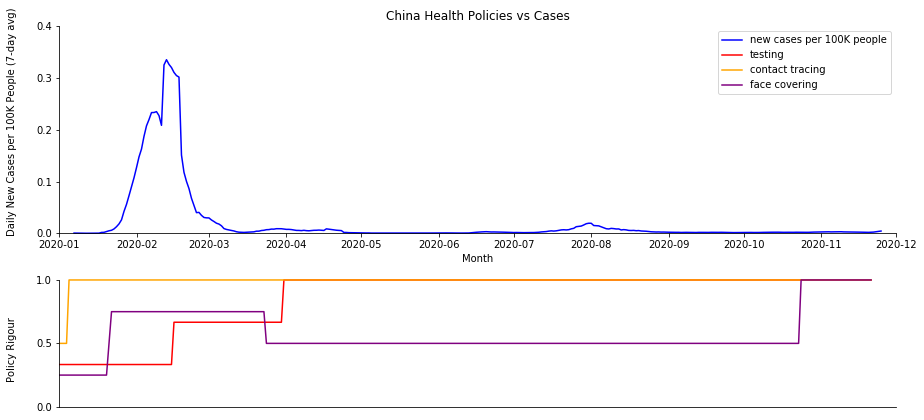

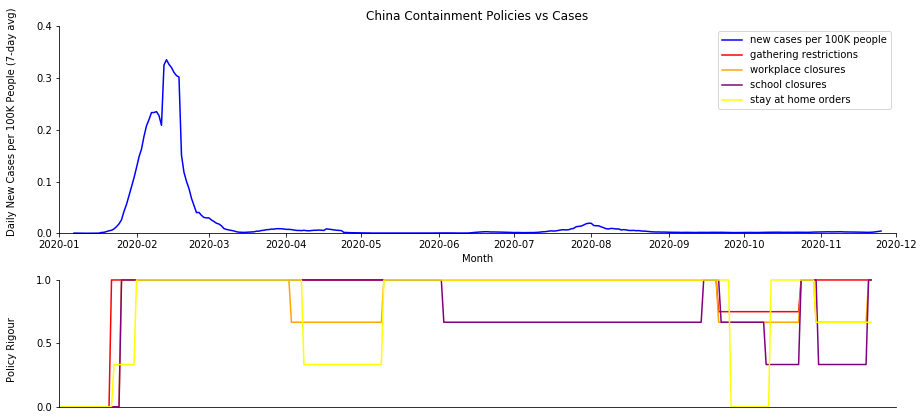

In [11]:
plot_health_policies(cn_epi_df, cn_gr_df, cn_fc_df, cn_demo_df, 'China')
plot_containment_policies(cn_epi_df, cn_gr_df, cn_demo_df, 'China')